In [1]:
import riversim
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import integrate

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for std::pair<unsigned long, unsigned long> already registered; second conversion method ignored.


In [2]:
def seriesParamsEvaluation(model, n, m):
    model.initializeDirichlet()

    model.rivers[1].addPoint(riversim.Polar(0.1, 0), 0)

    boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, 0.00001, 0, 0)
    triangle = riversim.Triangle(model.mesh_params)
    triangle.mesh_params.tip_points = model.rivers.tipPoints()

    mesh = triangle.generate(boundary, model.region.holes)

    solver = riversim.Solver(model.solver_params, True)
    start = time.time()
    solver.openMesh(mesh)
    for i in range(1 + model.solver_params.adaptive_refinment_steps):
        if i > 0:
            solver.refineGrid()
        solver.setupSystem()
        solver.assembleSystem(model.boundary_conditions)
        solver.solve()
    end = time.time() - start

    tip_angle = model.rivers[1].tipAngle()
    tip_coord = model.rivers[1].tipPoint()
    series_params_orig = solver.integrate_new(model.integr_params, tip_coord, tip_angle)

    
    integral = [0, 0, 0]
    normalization = [0, 0, 0]
    drho = model.integr_params.integration_radius / n
    for rho in np.arange(drho, model.integr_params.integration_radius, drho):
        weight_func_value = model.integr_params.weightFunction(rho)
        for phi in np.arange(0, 2 * np.pi, np.pi / m / rho * model.integr_params.integration_radius):
            cylind_coord = riversim.Polar(rho, phi)
            abs_coord = riversim.Point(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle))
            rel_coord = abs_coord - tip_coord
            try:
                sol_value = solver.value(abs_coord)
            except:
                continue

            for param_index in range(3):
                base_vector_value = model.integr_params.baseVectorFinal(param_index + 1, tip_angle, rel_coord.x, rel_coord.y);
                integral[param_index] += sol_value * weight_func_value * base_vector_value * rho
                normalization[param_index] += weight_func_value * np.power(base_vector_value, 2) * rho

    series_params_my = [integ / norm for integ, norm in zip(integral, normalization)]
    solver.outputResults("integral_research")

    return {"averageSolverError": solver.averageCellError(),
            "maxSolverError": solver.maxCellError(), 
            "seriesParamsOrig": [series_params_orig[0], series_params_orig[1], series_params_orig[2]],
            "seriesParamsMy": series_params_my, 
            "dof": solver.numberOfDOFs(),
            "numberOfCells": solver.numberOfCells(), 
            "solverTime": end}

## Tip Field

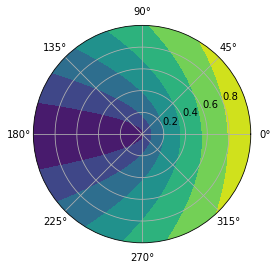

In [9]:
azimuths = np.radians(np.linspace(-180, 180, 360))
zeniths = np.arange(0, 1, 0.0001)

r, theta = np.meshgrid(zeniths, azimuths)

a1 = 1
a2 = 0.03
a3 = 0.015
values = a1 * np.sqrt(r) * np.cos(theta/2) + a2 * r * np.sin(theta) + a3 * np.power(r, 3/2) * np.cos(3*theta/2)

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(subplot_kw = dict(projection='polar'))
ax.contourf(theta, r, values)

plt.show()

## SciPy чисельний інтеграл

### Gauss Quadrature

In [24]:
integrate.dblquad(lambda rho, phi: np.sqrt(rho) * np.cos(phi/2), 0., 2. * np.pi, 0., 0.798, epsabs=1e-10)

(1.0002893840882976, 1.1105443055029447e-14)

### Приклад

In [4]:
integrate.dblquad(lambda x, y: np.sin(x*y), 0., 1, 0., 1, epsabs=1e-14)

(0.2398117420005647, 5.094460170817101e-15)

### Заготовка до роботи. Тобто обчислене поле.

In [6]:
model = riversim.Model()
model.initializeDirichlet()

model.rivers[1].addPoint(riversim.Polar(0.1, 0), 0)

boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, 0.00001, 0, 0)
triangle = riversim.Triangle(model.mesh_params)
triangle.mesh_params.tip_points = model.rivers.tipPoints()

mesh = triangle.generate(boundary, model.region.holes)

solver = riversim.Solver(model.solver_params, True)
start = time.time()
solver.openMesh(mesh)
for i in range(1 + model.solver_params.adaptive_refinment_steps):
    if i > 0:
        solver.refineGrid()
    solver.setupSystem()
    solver.assembleSystem(model.boundary_conditions)
    solver.solve()
end = time.time() - start

tip_angle = model.rivers[1].tipAngle()
tip_coord = model.rivers[1].tipPoint()
series_params_orig = solver.integrate_new(model.integr_params, tip_coord, tip_angle)
    
integral = [0, 0, 0]
normalization = [0, 0, 0]
integral_l = 0
normalization_l = 0
integral_l_func = lambda rho, phi:  solver.valueSafe(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle)) * model.integr_params.weightFunction(rho) * model.integr_params.baseVectorFinal(2, tip_angle, rho * np.cos(phi + tip_angle), rho * np.sin(phi + tip_angle)) * rho
normalization_l_func = lambda rho, phi:  model.integr_params.weightFunction(rho) * np.power(model.integr_params.baseVectorFinal(2, tip_angle, rho * np.cos(phi + tip_angle), rho * np.sin(phi + tip_angle)), 2) * rho
drho = model.integr_params.integration_radius / 8
for rho in np.arange(drho, model.integr_params.integration_radius, drho):
    weight_func_value = model.integr_params.weightFunction(rho)
    for phi in np.arange(0, 2 * np.pi, np.pi / 4200 / rho * model.integr_params.integration_radius):
        cylind_coord = riversim.Polar(rho, phi)
        abs_coord = riversim.Point(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle))
        rel_coord = abs_coord - tip_coord
        try:
            sol_value = solver.value(abs_coord)
        except:
            continue

        for param_index in range(3):
            base_vector_value = model.integr_params.baseVectorFinal(param_index + 1, tip_angle, rel_coord.x, rel_coord.y);
            integral[param_index] += sol_value * weight_func_value * base_vector_value * rho
            normalization[param_index] += weight_func_value * np.power(base_vector_value, 2) * rho

        integral_l += integral_l_func(rho, phi)
        normalization_l += normalization_l_func(rho, phi)
            
series_params_my = [integ / norm for integ, norm in zip(integral, normalization)]

In [7]:
print("integral = " + str(integral_l))
print("normalization = " + str(normalization_l))
print("series param = " + str(integral_l/normalization_l))
print(series_params_my[1])
print(series_params_orig[1])
print("error = " + str(1 - series_params_my[1]/series_params_orig[1]))

integral = 0.000142492787405614
normalization = 0.002465154215766097
series param = 0.05780278835875242
0.05780278835875238
0.057802788358728034
error = -4.212186155427844e-13


## Numerical recipes

### Інтеграція трапецією

3.384838104248047
1.6969869136810303
0.0005035400390625
8.821487426757812e-05
6722.083333333333
3370.113162878788
0.17518939393939395
(3.1415926524946025, 6.374330581628277e-10, 22)
(3.1415926523800475, 7.040775529486099e-10, 21)
3.1415926535897967
3.1430279111285824
3.141592653589793
3.486099969078068e-10
1.1308638867425824e-15


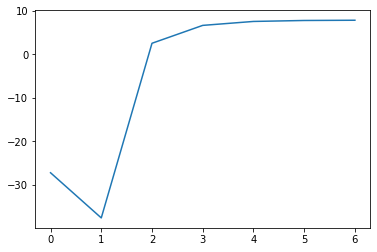

In [4]:
# integration
class Quadrature:
    def __init__(self, n):
        self.n = n
    def next():
        pass

class Trapzd(Quadrature):
  def __init__(self, func, a, b):
    self.func = func
    self.a = a
    self.b = b
    self.n = 0
    self.s = 0

  def next(self):
    self.n += 1
    if self.n == 1:
        self.s = 0.5 * (self.b - self.a) * (self.func(self.a) + self.func(self.b))
    else:
        tnm = np.power(2, self.n - 2)
        d = (self.b - self.a) / tnm
        x = self.a + 0.5 * d
        sum = 0
        for j in np.arange(0, tnm):
            sum += self.func(x)
            x += d
        self.s = 0.5 * (self.s + (self.b - self.a) * sum / tnm)

    return self.s

t = Trapzd(lambda x: x*np.sin(x), 0, 10)
I_series = [t.next() for i in range(7)]
plt.plot(I_series)

def qtrap(func, a, b, eps = 1e-10):
    jmax = 30
    s = olds = 0
    t = Trapzd(func, a, b)
    for i in range(jmax):
        s = t.next()
        if i > 5:
            cur_eps = abs(s - olds) / abs(olds)
            if cur_eps < eps or (s == 0. and olds == 0.):
                return (s, cur_eps, t.n)
        olds = s
    
    raise Exception('Too many steps in routine qtrap')

def qsimp(func, a, b, eps = 1e-10):
    jmax = 30
    s = st = ost = os = 0
    t = Trapzd(func, a, b)
    for i in range(jmax):
        st = t.next()
        s = (4. * st - ost) / 3.
        if i > 5:
            cur_eps = abs(s - os) / abs(os)
            if cur_eps < eps or (s == 0. and os == 0.):
                return (s, cur_eps, t.n)
        os = s
        ost = st
    
    raise Exception('Too many steps in routine qsimp')

#def qromb(func, a, b, eps = 1e-10):
#    jmax = 20
#    jmaxp = jmax + 1
#    k = 5
#    s = [0] * jmax
#    h = [0] * jmaxp
#    h[0] = 1
#    t = Trapzd(func, a, b)
#    for j in range(1, jmax):
#        s[j-1] = t.next()
#        if j >= k:
#            ss =  

def qgaus(func, a, b):
    x = [0.1488743389816312,0.4333953941292472,\
        0.6794095682990244,0.8650633666889845,0.9739065285171717]
    w = [0.2955242247147529,0.2692667193099963,\
        0.2190863625159821,0.1494513491505806,0.0666713443086881]
    xm = (b + a) / 2.
    xr = (b - a) / 2.
    s = 0
    for j in range(5):
        dx = xr * x[j]
        s += w[j] * (func(xm +dx) + func(xm - dx))
    s = s * xr
    return s



I_time = time.time()
I_qtrap = qtrap(lambda x: 2*np.sqrt(1 - x*x), -1, 1, 1e-9)
I_time = time.time() - I_time
I_qsimp_time = time.time()
I_qsimp = qsimp(lambda x: 2*np.sqrt(1 - x*x), -1, 1, 1e-9)
I_qsimp_time = time.time() - I_qsimp_time
I_scipy_time = time.time()
I_scipy = integrate.quad(lambda x: 2*np.sqrt(1 - x*x), -1, 1, epsrel = 1e-9)
I_scipy_time = time.time() - I_scipy_time
I_qgaus_time = time.time()
I_qgaus = qgaus(lambda x: 2*np.sqrt(1 - x*x), -1, 1)
I_qgaus_time = time.time() - I_qgaus_time

print(I_time)
print(I_qsimp_time)
print(I_scipy_time)
print(I_qgaus_time)
print(I_time/I_scipy_time)
print(I_qsimp_time/I_scipy_time)
print(I_qgaus_time/I_scipy_time)
print(I_qtrap)
print(I_qsimp)
print(I_scipy[0])
print(I_qgaus)
print(np.pi)
print(abs(np.pi - I_qtrap[0]) / I_qtrap[0])
print(abs(np.pi - I_scipy[0]) / I_scipy[0])

## Різне

In [8]:
integral_l = integrate.dblquad(integral_l_func, 0., 2.*np.pi, 0., model.integr_params.integration_radius, epsabs=1e-14)
normalization_l = integrate.dblquad(normalization_l_func, 0., 2.*np.pi, 0, model.integr_params.integration_radius, epsabs=1e-14)
a2 = integral_l[0]/normalization_l[0]
print("integral = " + str(integral_l[0]))
print("normalization = " + str(normalization_l[0]))
print(a2)
print(series_params_orig[1])
print("error = " + str(a2/series_params_orig[1]))

/home/oleg/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/oleg/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


integral = 9.071697037860584e-10
normalization = 1.568857810125399e-08
0.057823576995390556
0.057802788358728034
error = 1.0003596476442194


In [12]:
test_int_1 = integrate.dblquad(lambda phi_1, rho_1: rho_1, 0., 2.*np.pi, 0., 1)
test_int_2 = integrate.dblquad(lambda rho_1, phi_1: rho_1, 0., 2.*np.pi, 0., 1)
#test_int_3 = integrate.dblquad(lambda rho_1, phi_1: np.array([1, 1, 1]), 0., 1, 0., 1)
print(test_int_1)
print(test_int_2)
#print(test_int_3)
print(np.pi * np.power(model.integr_params.integration_radius, 2))
print(2.*np.pi)

(19.739208802178716, 2.1914924100062368e-13)
(3.141592653589793, 3.487868498008632e-14)
0.0028274333882308137
6.283185307179586


In [3]:
model = riversim.Model()
n = 8
m = 4200
result = seriesParamsEvaluation(model, n, m)
print(result)

{'averageSolverError': 7.606431220968564e-05, 'maxSolverError': 0.0007592121255584061, 'seriesParamsOrig': [0.0906574888281114, 0.057802788358728034, 0.11243172053173604], 'seriesParamsMy': [0.09065711441798233, 0.05780278835875238, 0.11106826338192946], 'dof': 8779, 'numberOfCells': 960}


Отже.. які збіжності ми хочемо перевірити?
 - Помилка самого солвера фем
 - розмір сітки
 - кількість поділів при обрахунку інтегралу

In [ ]:
model = riversim.Model()
model.initializeDirichlet()
model.solver_params.adaptive_refinment_steps = 20

adaptive_steps = np.arange(model.solver_params.adaptive_refinment_steps + 1)
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
dof = []
cells = []

model.rivers[1].addPoint(riversim.Polar(0.1, 0), 0)

boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, 0.00001, 0, 0)
triangle = riversim.Triangle(model.mesh_params)
triangle.mesh_params.tip_points = model.rivers.tipPoints()

mesh = triangle.generate(boundary, model.region.holes)

solver = riversim.Solver(model.solver_params, True)
solver.openMesh(mesh)
for i in range(1 + model.solver_params.adaptive_refinment_steps):
    if i > 0:
        solver.refineGrid()
    solver.setupSystem()
    solver.assembleSystem(model.boundary_conditions)
    solver.solve()

    tip_angle = model.rivers[1].tipAngle()
    tip_coord = model.rivers[1].tipPoint()
    series_params_orig = solver.integrate_new(model.integr_params, tip_coord, tip_angle)

    integral = [0, 0, 0]
    normalization = [0, 0, 0]
    drho = model.integr_params.integration_radius / n
    for rho in np.arange(drho, model.integr_params.integration_radius, drho):
        weight_func_value = model.integr_params.weightFunction(rho)
        for phi in np.arange(0, 2 * np.pi, np.pi / m / rho * model.integr_params.integration_radius):
            cylind_coord = riversim.Polar(rho, phi)
            abs_coord = riversim.Point(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle))
            rel_coord = abs_coord - tip_coord
            try:
                sol_value = solver.value(abs_coord)
            except:
                continue

            for param_index in range(3):
                base_vector_value = model.integr_params.baseVectorFinal(param_index + 1, tip_angle, rel_coord.x, rel_coord.y);
                integral[param_index] += sol_value * weight_func_value * base_vector_value * rho
                normalization[param_index] += weight_func_value * np.power(base_vector_value, 2) * rho

    series_params_my = [integ / norm for integ, norm in zip(integral, normalization)]
    solver.outputResults("integral_research")

    result = {"averageSolverError": solver.averageCellError(),
            "maxSolverError": solver.maxCellError(), 
            "seriesParamsOrig": [series_params_orig[0], series_params_orig[1], series_params_orig[2]],
            "seriesParamsMy": series_params_my, 
            "dof": solver.numberOfDOFs(),
            "numberOfCells": solver.numberOfCells()}
    print(i)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])

Text(0.5, 113.99999999999989, 'number of adaptive steps')

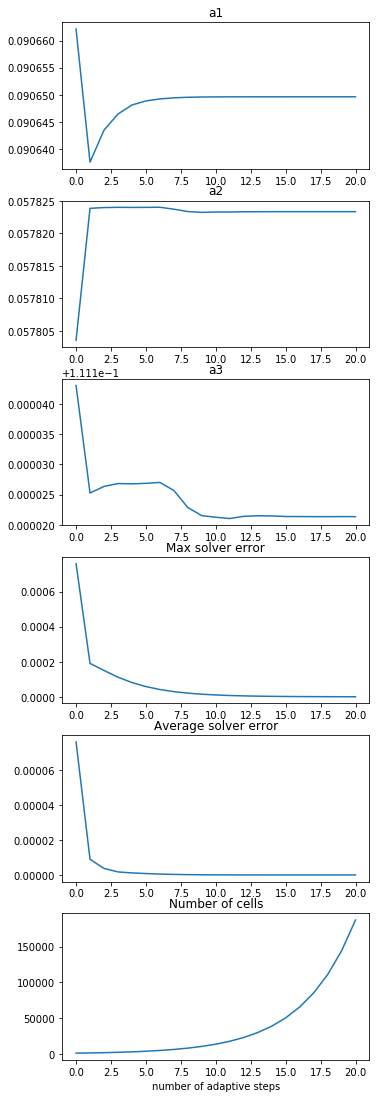

In [47]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(adaptive_steps, series_param_1)
ax[0].set_title("a1")
ax[1].plot(adaptive_steps, series_param_2)
ax[1].set_title("a2")
ax[2].plot(adaptive_steps, series_param_3)
ax[2].set_title("a3")
ax[3].plot(adaptive_steps, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(adaptive_steps, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(adaptive_steps, cells)
ax[5].set_title("Number of cells")
ax[5].set_xlabel("number of adaptive steps")

Отже на всіх графіках однозначно видно збіжність.

In [49]:
print(series_param_1)
print(series_param_2)
print(series_param_3)
print(max_solver_error)
print(avrg_solver_error)
print(cells)
print(series_param_1[0])
print(series_param_1[-1])
print(series_param_2[0])
print(series_param_2[-1])
print(series_param_3[0])
print(series_param_3[-1])
print(max_solver_error[0])
print(max_solver_error[-1])
print(avrg_solver_error[0])
print(avrg_solver_error[-1])
print(cells[0])
print(cells[-1])

[0.0906621248360517, 0.09063755967112297, 0.09064346569551363, 0.09064643629444243, 0.09064810500647205, 0.09064886268209482, 0.09064922355313179, 0.09064943014122642, 0.09064953497857937, 0.09064958181250256, 0.09064960425871763, 0.09064961503532187, 0.0906496164889809, 0.09064961891927951, 0.09064962068789499, 0.09064962208272465, 0.0906496225338238, 0.09064962267721396, 0.09064962278156673, 0.09064962288474514, 0.09064962290127289]
[0.05780355059070401, 0.05782385331843312, 0.05782396972173536, 0.057824007324163255, 0.05782399115826438, 0.05782400040516402, 0.05782401913168716, 0.057823721156931976, 0.0578233565685546, 0.057823229778724436, 0.05782329114477852, 0.05782328781245319, 0.05782332394016378, 0.057823332435981256, 0.05782333698935704, 0.05782334368230641, 0.05782334295600021, 0.05782334071473288, 0.057823340040938136, 0.057823340176284856, 0.05782334023098132]
[0.11114309403935013, 0.1111252681124333, 0.11112636022698988, 0.11112683783232248, 0.11112678874353732, 0.1111268

Тепер розглянемо збіжність просто по самому солверу.

In [75]:
model = riversim.Model()
tolerance = [1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.solver_params.tollerance in tolerance:
    result = seriesParamsEvaluation(model, 8, 4200)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])

Text(0.5, 113.99999999999989, 'tollerance')

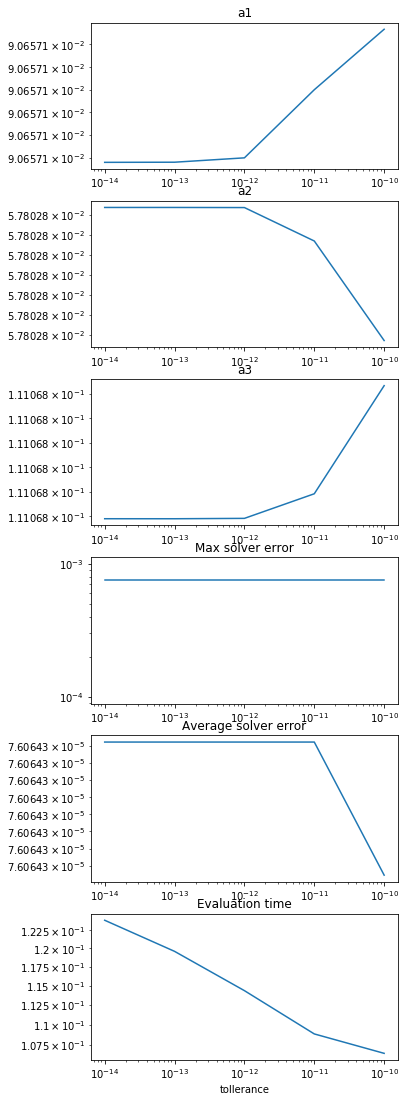

In [76]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].loglog(tolerance, series_param_1)
ax[0].set_title("a1")
ax[1].loglog(tolerance, series_param_2)
ax[1].set_title("a2")
ax[2].loglog(tolerance, series_param_3)
ax[2].set_title("a3")
ax[3].loglog(tolerance, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].loglog(tolerance, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].loglog(tolerance, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("tollerance")

In [78]:
series_param_3[0] - series_param_3[-1]

1.0883795392713225e-09

Тепер спорбує глянути як змінююється розвязок в залежності від порядку скінченного елементу.

In [90]:
model = riversim.Model()
model.solver_params.tollerance = 1e-15
quadrature_degree = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.solver_params.quadrature_degree in quadrature_degree:
    result = seriesParamsEvaluation(model, 8, 4200)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])

Text(0.5, 113.99999999999989, 'quadrature degree')

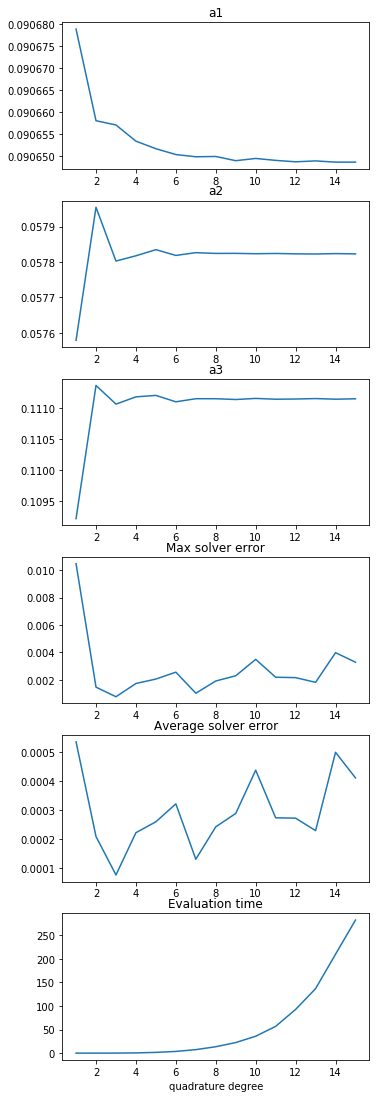

In [86]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(quadrature_degree, series_param_1)
ax[0].set_title("a1")
ax[1].plot(quadrature_degree, series_param_2)
ax[1].set_title("a2")
ax[2].plot(quadrature_degree, series_param_3)
ax[2].set_title("a3")
ax[3].plot(quadrature_degree, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(quadrature_degree, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(quadrature_degree, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("quadrature degree")

In [88]:
print(series_param_1[-1])
print(series_param_2[-1])
print(series_param_3[-1])

0.09064865177866797
0.0578230643110854
0.11115436826223413


Text(0.5, 113.99999999999989, 'quadrature degree')

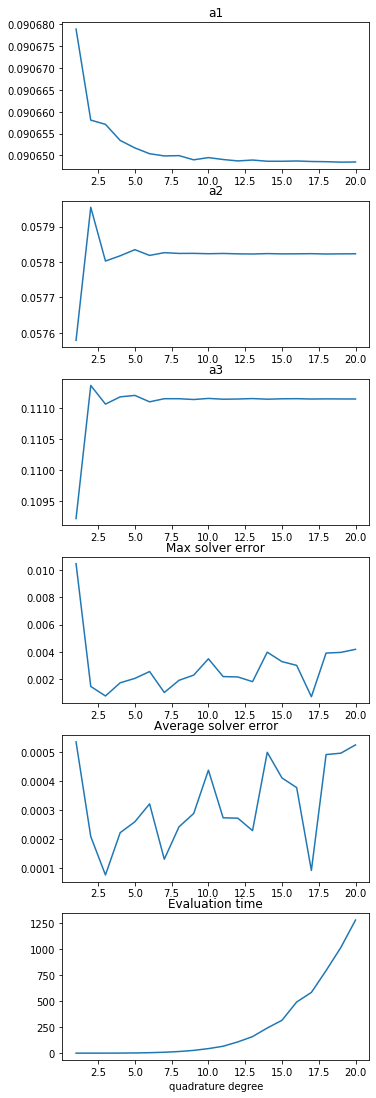

In [91]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(quadrature_degree, series_param_1)
ax[0].set_title("a1")
ax[1].plot(quadrature_degree, series_param_2)
ax[1].set_title("a2")
ax[2].plot(quadrature_degree, series_param_3)
ax[2].set_title("a3")
ax[3].plot(quadrature_degree, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(quadrature_degree, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(quadrature_degree, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("quadrature degree")

Розмір мешу тепер будемо змінювати

In [3]:
model = riversim.Model()
model.solver_params.tollerance = 1e-15
quadrature_degree = [1, 2, 3, 4]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.solver_params.quadrature_degree in quadrature_degree:
    result = seriesParamsEvaluation(model, 8, 4200)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])

In [4]:
model.integr_params.integration_radius

0.03

In [5]:
model.mesh_params.refinment_radius

0.005

In [23]:
print(model.mesh_params)
print(model.integr_params)

{
    "exponant": 1.0,
    "ignored_smoothness_length": 0.05,
    "max_area": 100000.0,
    "max_edge": 1.0,
    "min_angle": 32.0,
    "min_area": 6e-07,
    "min_edge": 8e-12,
    "ratio": 2.3,
    "refinment_radius": 0.005,
    "sigma": 1.9,
    "smoothness_degree": 0.5
}
{
    "exponant": 2.0,
    "integration_radius": 0.03,
    "weigth_func_radius": 0.01
}


0.03


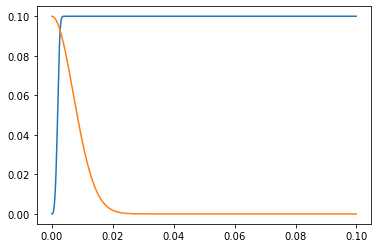

In [37]:
model = riversim.Model()
model.mesh_params.tip_points.append(riversim.Point(0, 0))
model.mesh_params.sigma = 0.005
model.mesh_params.exponant = 3
model.mesh_params.min_area = 6e-10
model.mesh_params.max_area = 1e-1
model.mesh_params.min_edge = 1e-13
model.mesh_params.refinment_radius = 0.05
print(model.integr_params.integration_radius)
r = np.arange(0, 0.1, 0.0001)
areaFunc = [model.mesh_params.meshAreaConstraint(x, 0) for x in r]
weightFunc = [0.1*model.integr_params.weightFunction(x) for x in r]
plt.plot(r, areaFunc, r, weightFunc)

In [31]:


model.solver_params.tollerance = 1e-15
model.solver_params.quadrature_degree = 7
sigma = [0.005, 4]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.mesh_params.sigma in sigma:
    print(model.mesh_params.sigma)

    result = seriesParamsEvaluation(model, 8, 4200)
    
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])


0.005
4.0


Text(0.5, 113.99999999999989, 'sigma')

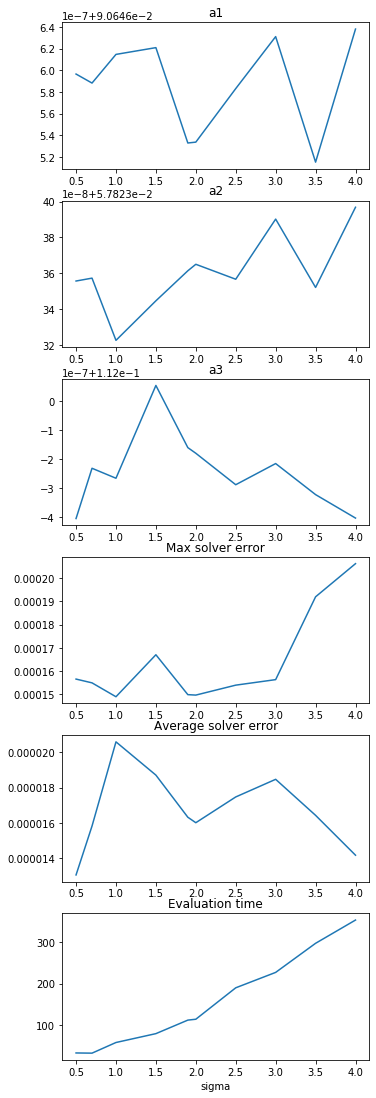

In [64]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(sigma, series_param_1)
ax[0].set_title("a1")
ax[1].plot(sigma, series_param_2)
ax[1].set_title("a2")
ax[2].plot(sigma, series_param_3)
ax[2].set_title("a3")
ax[3].plot(sigma, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(sigma, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(sigma, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("sigma")

In [66]:
print(series_param_1[-1])
print(series_param_2[-1])
print(series_param_3[-1])

0.09064663809200912
0.05782339680416207
0.1119995961500431


Text(0.5, 113.99999999999989, 'sigma')

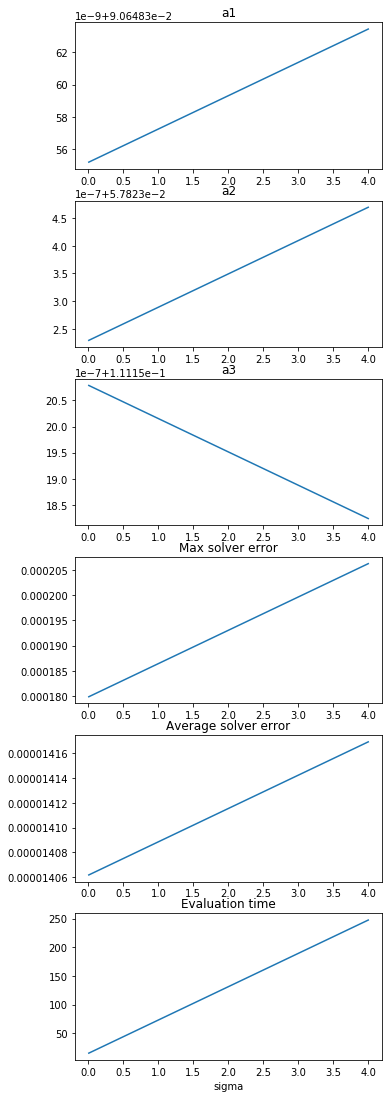

In [38]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(sigma, series_param_1)
ax[0].set_title("a1")
ax[1].plot(sigma, series_param_2)
ax[1].set_title("a2")
ax[2].plot(sigma, series_param_3)
ax[2].set_title("a3")
ax[3].plot(sigma, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(sigma, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(sigma, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("sigma")

In [32]:
series_param_1

[0.09064835520531252, 0.09064836342677941]